<a href="https://colab.research.google.com/github/Franeyotic777/MyProjects/blob/main/whatsapp_chat_group_analysis%2C_sentiment_analysis_and_topic_modelling_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Overview*
- Introduction
- Data Retrieval & Preprocessing
- Exploratory Data Analysis
- Data Visualization
- Data Interpretation
- Summarizing the Inferences
- Conclusion

In [12]:
!pip install emot

In [13]:
!pip install emoji
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools
from collections import Counter
import warnings

import emot
import os
import re
#import stylecloud
%matplotlib inline
warnings.filterwarnings('ignore')

##### NOTE:
- This special command `%matplotlib inline` to ensure that plots are shown and embedded within the Jupyter notebook itself. Without this command, sometimes plots may show up in pop-up windows.
- `warnings.filterwarnings('ignore')`: The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception). [REFERENCE](https://docs.python.org/3/library/warnings.html)

## *Preparation and reading data*

In [14]:
import pandas as pd
import re

def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr' : r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '12hr_nbsp' : r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\u202F-\s',
        '24hr' : r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '12hr_nbsp' : '%d/%m/%Y, %I:%M %p\u202F- ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string)[1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df

    # Handling different date formats in the data
    def parse_date(date_str):
        for fmt in ['%d/%m/%Y, %I:%M %p - ', '%m/%d/%y, %I:%M %p - ', '%d/%m/%y, %I:%M %p - ']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        raise ValueError(f"time data '{date_str}' does not match any expected format")

    # converting date-time pattern which is of type String to type datetime,
    df['date_time'] = df['date_time'].apply(parse_date)

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split(r'([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and splitting it aka each msg from a user
        if a[1:]: # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)

    return df

# Use the function with the correct format key
df = rawToDf('whatsapp-chat-data.txt', '12hr')
print(df.head())


            date_time                user  \
0 2020-01-26 16:19:00  group_notification   
1 2020-01-24 20:25:00  group_notification   
2 2020-01-26 16:19:00  group_notification   
3 2020-01-26 16:20:00  group_notification   
4 2020-01-26 16:20:00  group_notification   

                                             message  
0  Messages and calls are end-to-end encrypted. N...  
1  Tanay Kamath (TSEC, CS) created group "CODERS👨...  
2         You joined using this group's invite link   
3  +91 99871 38558 joined using this group's invi...  
4  +91 91680 38866 joined using this group's invi...  


#### *NOTE*:
- Since WhatsApp texts are *multi-line*, you cannot just read the file line by line and get each message that you want. Instead, you need a way to *identify* if a line is a new message or part of an old message. You could use regular expressions.
- While reading each line, I split it based on a comma and take the first item returned from the `split()` function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.

## *Prior Information of my Whatsapp Data*
- This is my most active college coding group.
- It has **235+** participants; 237 to be precise.
- This group was made in **January 2020.**

## Pre-Processing

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [16]:
df.sample(10)

,date_time,user,message
918,2020-02-17 13:57:00,"Mohit Varma (TSEC, CS)",<Media omitted>
1713,2020-02-22 16:32:00,group_notification,+91 99695 65480 joined using this group's invi...
7096,2020-06-05 18:08:00,+91 97681 67131,It would have pixel experience rom see that’s ...
3618,2020-03-21 14:43:00,+91 80979 84068,This message was deleted
13360,2020-09-29 18:43:00,"Harsh Kapadia (TSEC IT, SE)",
12078,2020-09-13 17:12:00,"Dheeraj Lalwani (TSEC, CS)",😂
2266,2020-02-27 19:31:00,+91 98206 01141,Yes
3857,2020-03-24 21:01:00,+91 84335 18102,Lecter?
12816,2020-09-23 09:37:00,+91 82916 21138,True 😂
9935,2020-08-13 15:16:00,+91 75078 05454,haa uska dhyan rakhna padega😂


### An important observation
- One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an *empty string.*
- This can be because, the message might just contain **emojis.**
#### To see, how many such rows are there, we can use `df[df['message'] == ""].shape[0]`

In [17]:
df[df['message'] == ""].shape[0]

538

## Adding extra *helper columns for analysis and visualization*

In [18]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

# Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.
### Final Data Frame

In [19]:
df

,date_time,user,message,day,month,year,date
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sun,Jan,2020,2020-01-26
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Fri,Jan,2020,2020-01-24
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sun,Jan,2020,2020-01-26
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sun,Jan,2020,2020-01-26
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sun,Jan,2020,2020-01-26
...,...,...,...,...,...,...,...
13650,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,Fri,Oct,2020,2020-10-02
13651,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,Fri,Oct,2020,2020-10-02
13652,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,Fri,Oct,2020,2020-10-02
13653,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,Fri,Oct,2020,2020-10-02


# *Data Analysis*

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist).**
- Ghosts present in the group. (shocking results.)

**4. Top 10 users most sent media.**

**5. Top 10 most used emojis.**

**6. Most active hours and days.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

# 1. Overall frequency of total messages on the group.
- I will first do this to get a look at overall data.

I will plot a simple line graph to see the frequency of messages over the months.
##### I expect to see a nice line graph with crests and troughs in odd places.

In [20]:
import pandas as pd

# Assuming df is your original DataFrame and it has a 'date' column of datetime type.
df1 = df.copy()  # Make a copy of the original DataFrame to avoid data loss
df1['message_count'] = 1  # Add a helper column for counting messages
df1.drop(columns='year', inplace=True)  # Drop unnecessary 'year' column

# Ensure 'date' is in datetime format if not already
df1['date'] = pd.to_datetime(df1['date'])

# Group by 'date' and sum only the numerical columns
df1 = df1.groupby('date').agg({'message_count': 'sum'}).reset_index()

# Display the resulting DataFrame
print(df1)


          date  message_count
0   2020-01-24              1
1   2020-01-26            105
2   2020-01-27             90
3   2020-01-28            126
4   2020-01-29            118
..         ...            ...
237 2020-09-28            144
238 2020-09-29             49
239 2020-09-30            167
240 2020-10-01             91
241 2020-10-02             22

[242 rows x 2 columns]


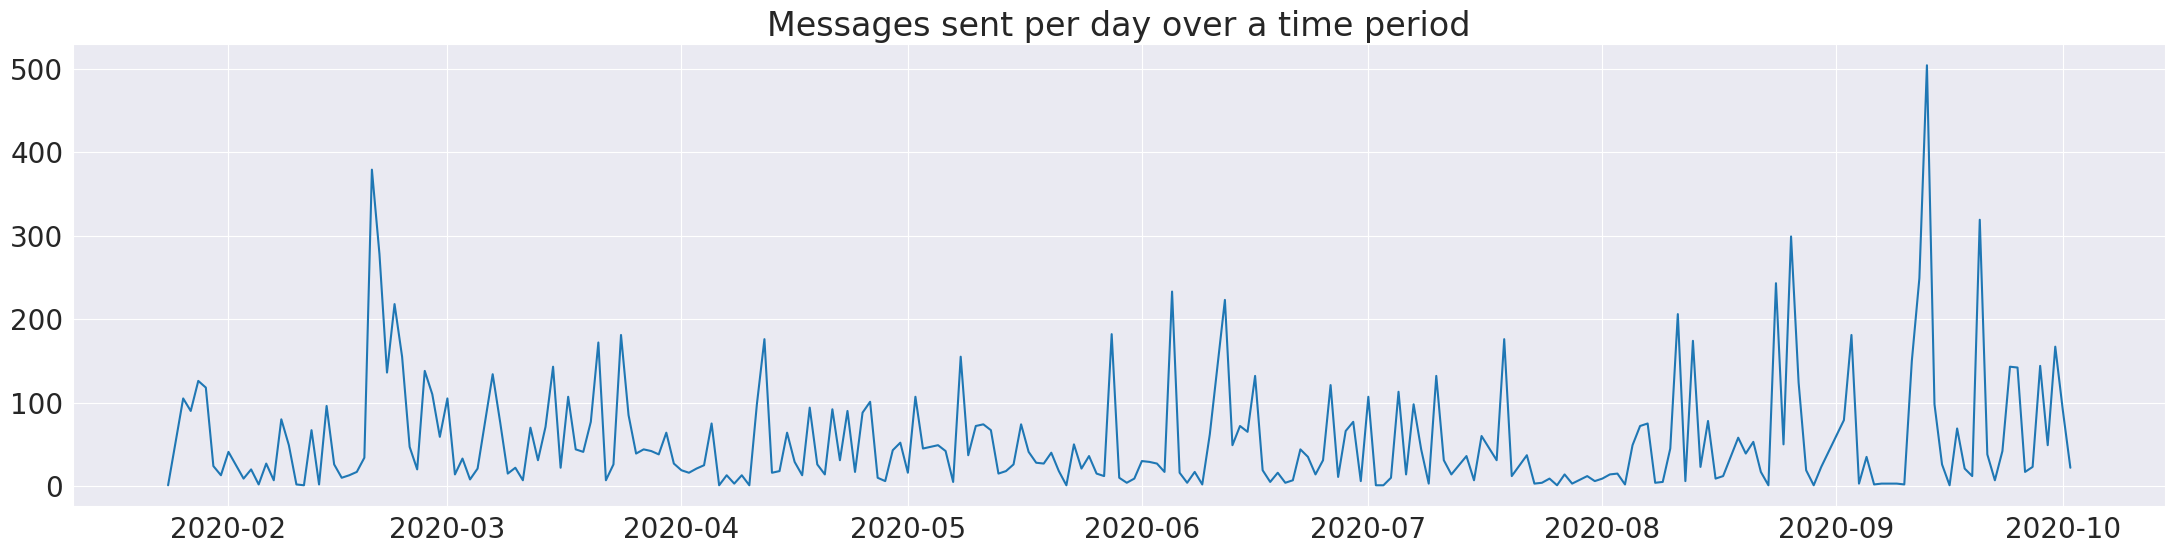

In [21]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# 2 *Top 10 most active days.*

In [22]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2020-09-13,504
1,2020-02-20,379
2,2020-09-20,319
3,2020-08-26,299
4,2020-02-21,278
5,2020-09-12,249
6,2020-08-24,243
7,2020-06-05,233
8,2020-06-12,223
9,2020-02-23,218


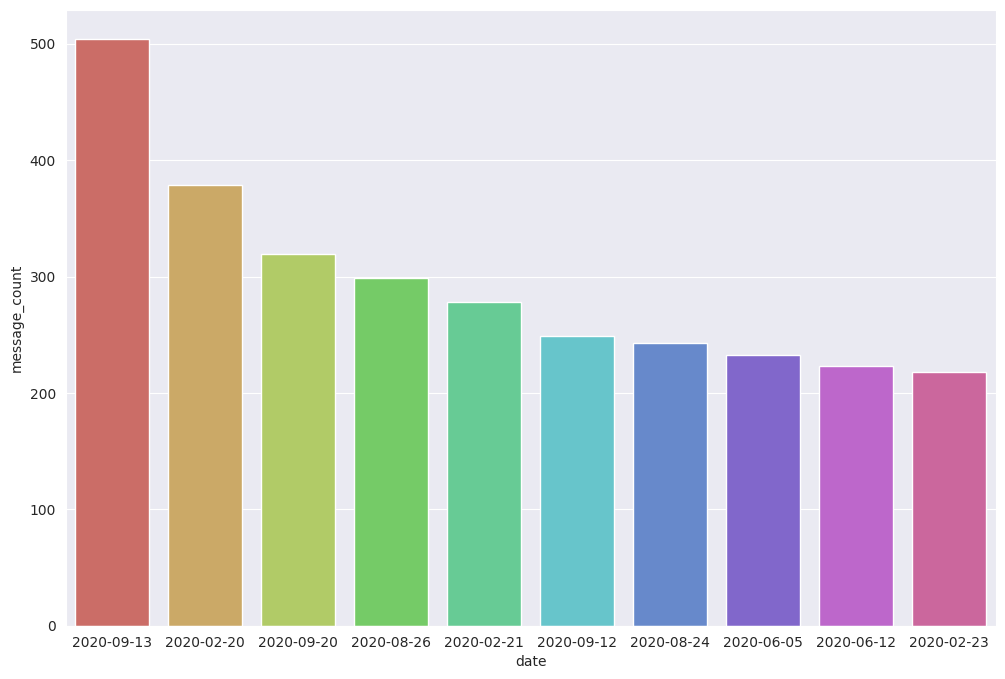

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving default styles using Seaborn
sns.set_style("darkgrid")

# For better readability
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Create a bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top10days, palette="hls")

# Saving the plot
plt.savefig('top10_days.svg', format='svg')

# Show the plot
plt.show()


#### Apparently, the group was very active on 13th Spetember'20
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [24]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

## Now, pre-processing top 10 active users.

In [25]:
df2 = df.copy()
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [26]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]

top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

### Starting with a basic plot.
- [Color References for Matplotlib](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

- **Improving Default Styles using Seaborn**

    - [References](https://seaborn.pydata.org/generated/seaborn.set_style.html)

In [27]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

##### Plotting a simple line graph.

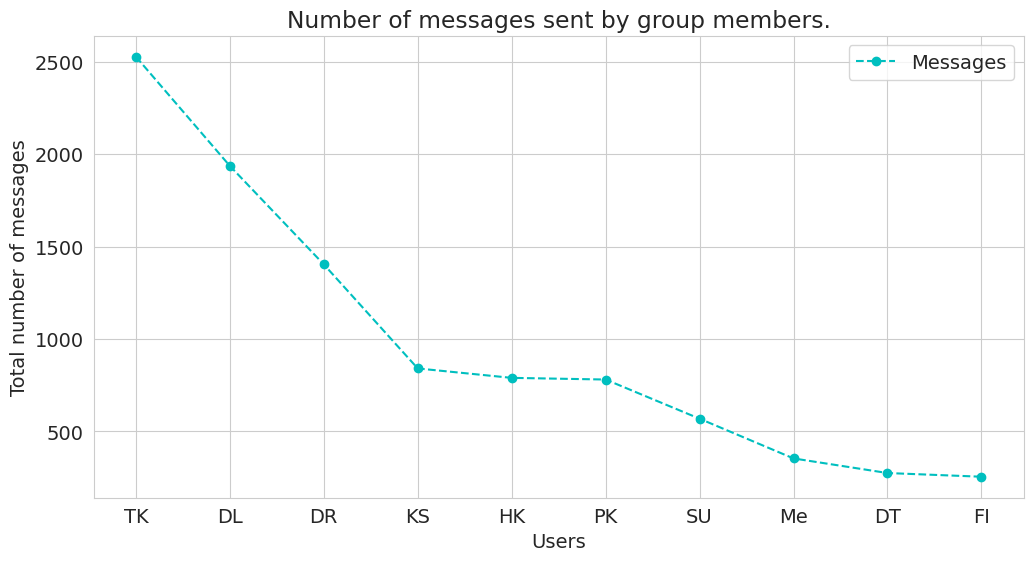

In [28]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')


# Labels and Title
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

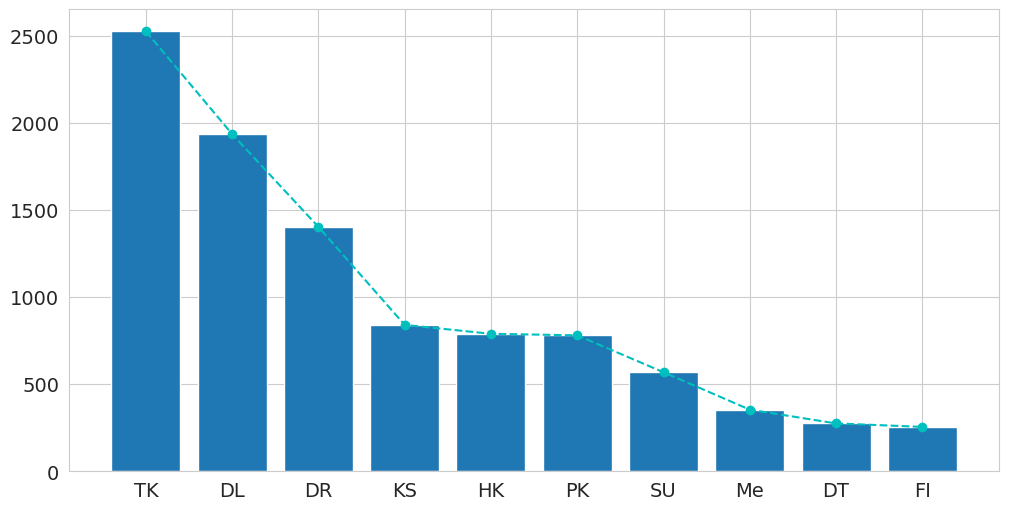

In [29]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

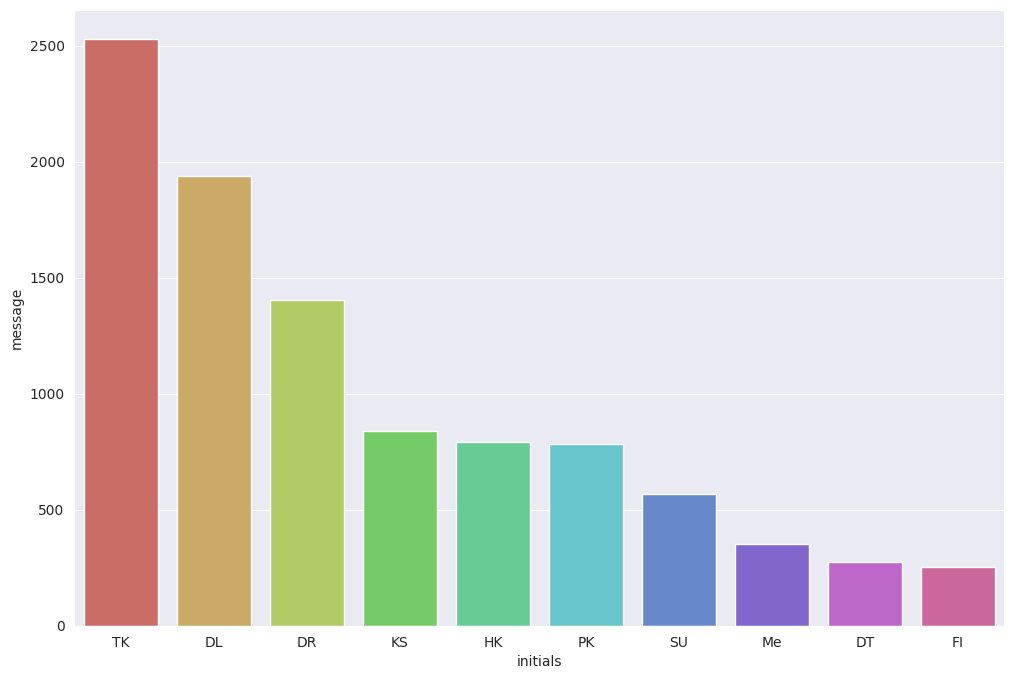

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving default styles using Seaborn
sns.set_style("darkgrid")

# For better readability
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Create a bar plot for top 10 initials and message count
sns.barplot(x='initials', y='message', data=top10df, palette="hls")

# Show the plot
plt.show()


# *Important Note*

- Since almost all the plots will be ***comparing* one person with another**, I’ll assign a **specific colour to each person** so that it becomes **easy to identify** each person among *multiple plots*.

- I could've used *seaborn's color palette* but:
    - Seaborn assigns default colors itself, but i wanted the color of a **certain person remains the same, no matter the plot**;
    - Also, I wanted to try some different colors so I grabbed my **colour palette** from https://coolors.co/

- Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the `pallete` argument in a seaborn plotting function.

## Defining a function to tackle the problem.

I'm defining the following function to ***maintain consistent colors for each person across all plots***. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that **the color of a certain person remains the same no matter the plot**. This will help maintain **consistency and readability** amongst the many graphs I will be plotting.


In [31]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''

    order = list(names_in_certain_order)
    return_list = []

    for name in order:
        return_list.append(color_dict[name])

    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

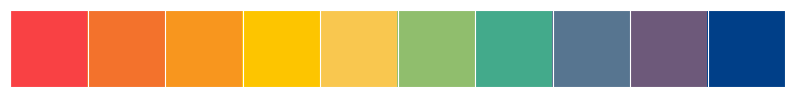

In [32]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [33]:
import pandas as pd
import re

# Assuming df is the parsed DataFrame from previous steps
df['message_length'] = df['message'].apply(len)

# Create a DataFrame for average message length per user
avg_msg_lengths = df.groupby('user')['message_length'].mean().reset_index().sort_values(by='message_length', ascending=False)

# Display the average message lengths
print(avg_msg_lengths.head(10))

# Example top 10 active users DataFrame for demonstration
top10_users = df['user'].value_counts().head(10).index.tolist()
top10df = df[df['user'].isin(top10_users)]

# Create a column for average message length in top10df
top10df = top10df.groupby('user').agg({
    'message': 'count',
    'message_length': 'mean'
}).reset_index()

# Sort the DataFrame by average message length
top10df_msg = top10df.sort_values(by='message_length', ascending=False)

print(top10df_msg)


                               user  message_length
75                  +91 93598 18687      367.500000
34                  +91 81696 11905      245.000000
76                  +91 94044 50783      232.800000
6                   +91 72762 35231      197.000000
1                   +91 70218 25025      144.166667
148  Shubham Chettiar (TSEC CS, TE)      124.068966
40                  +91 83292 66084      115.400000
0                   +91 70208 31915      106.000000
17                  +91 77158 99478      105.636364
23                  +91 77568 95072      101.000000
                          user  message  message_length
8               Tushar Nankani      354       57.920904
9           group_notification      276       50.539855
4     Kartik Soneji (TSEC, CS)      841       47.328181
0              +91 82916 21138      275       46.320000
5       Pratik K (TSEC CS, SE)      781       34.741357
3  Harsh Kapadia (TSEC IT, SE)      790       33.134177
6   Saurav Upoor (TSEC CS, SE)      

## Now, we will be plotting *most sent messages* and respective *average message lengths* simultaneously, to see some interesting results.
- Plotting multiple charts in a grid
    - Matplotlib and Seaborn also support plotting multiple charts in a grid, using `plt.subplots`, which returns a set of axes that can be used for plotting.

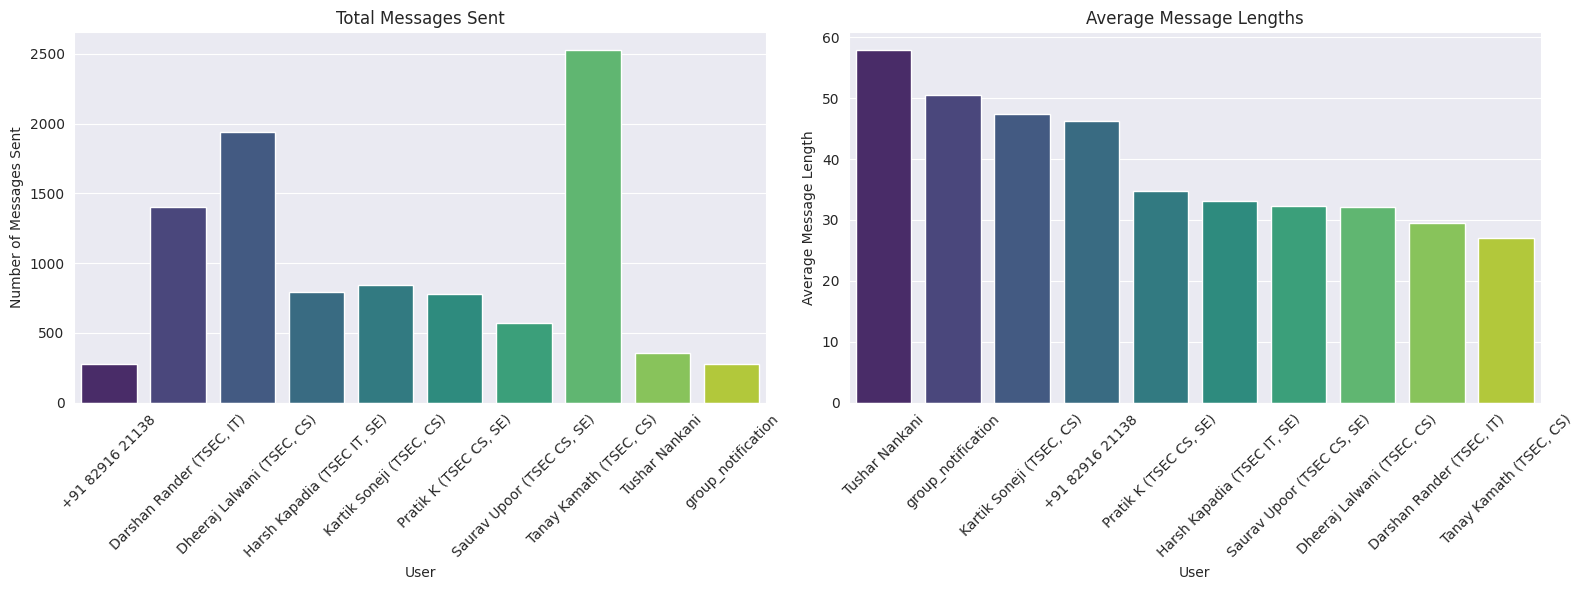

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data based on the previous steps
top10_users = df['user'].value_counts().head(10).index.tolist()
top10df = df[df['user'].isin(top10_users)]
top10df = top10df.groupby('user').agg({
    'message': 'count',
    'message_length': 'mean'
}).reset_index().rename(columns={'message': 'total_messages', 'message_length': 'avg_message_length'})

# Plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Define a palette
palette = sns.color_palette("viridis", len(top10df))

# Plot 1 - Countplot of total messages sent
sns.barplot(x='user', y='total_messages', data=top10df, ax=axes[0], palette=palette)

axes[0].set_title('Total Messages Sent')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(x='user', y='avg_message_length', data=top10df.sort_values(by='avg_message_length', ascending=False), ax=axes[1], palette=palette)

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Message Length')
axes[1].tick_params(axis='x', rotation=45)

# Saving the plots
plt.tight_layout()
plt.savefig('top10_msg_plots_diff.svg', format='svg')

# Display the plots
plt.show()


### It’s really interesting to see plots like this *side by side*, because here comes the twist:

- Ironically, **TK**, the person who sent the **most amount of texts** (2000+), has ***least*** messages' length on *average*. This means this person sends broken and many WhatsApp messages in one go.

- We can see that, **I** send less number of messages while having a **relatively longer message length**, followed by **KS**.

- Here's a **snippet** of how TK sends messages:

<img src="https://imgur.com/xznZczG.png">

#### "*Things aren't always the way they seem like.*"

# 4. Top 10 users most sent media

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`.

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [35]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

### *Visualization using different Seaborn's Color Palettes*
- [Seaborn References](http://seaborn.pydata.org/tutorial/color_palettes.html#using-circular-color-systems)
- [Seaborn's Different Colors](https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08)
- [Seaborn's Color Visualization](https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/)

###### QUICK HACK
- to get **all possible Seaborn's color palettes**:
    - Just put a random input `palette="xyz"`
    - It will then show an error, showing all possible palettes you can try out from!

### Which user sends the most media?

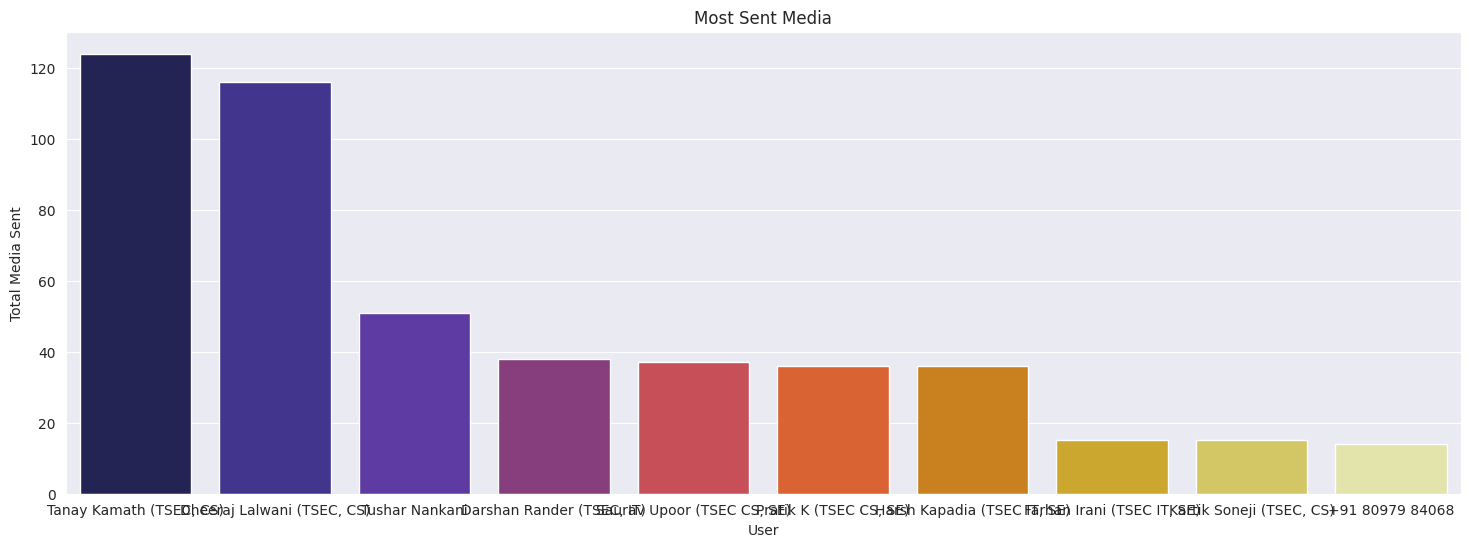

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


# Increasing the figure size
plt.figure(figsize=(18, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph
sns.barplot(x='user', y='media_sent', data=top10media, palette="CMRmap")

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent')

# Saving the plots
plt.savefig('top10media.svg', format='svg')

# Display the plot
plt.show()


### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [37]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.EMOJI_DATA.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [38]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"})
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin

    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,1886,face_with_tears_of_joy
1,👍,364,thumbs_up
2,🏻,247,light_skin_tone
3,🔥,244,fire
4,😅,220,grinning_face_with_sweat
5,💯,180,hundred_points
6,🤣,128,rolling_on_the_floor_laughing
7,👏,101,clapping_hands
8,🤦‍♂️,83,man_facepalming
9,🙏,79,folded_hands


### Which Emoji is the most used in the chat?

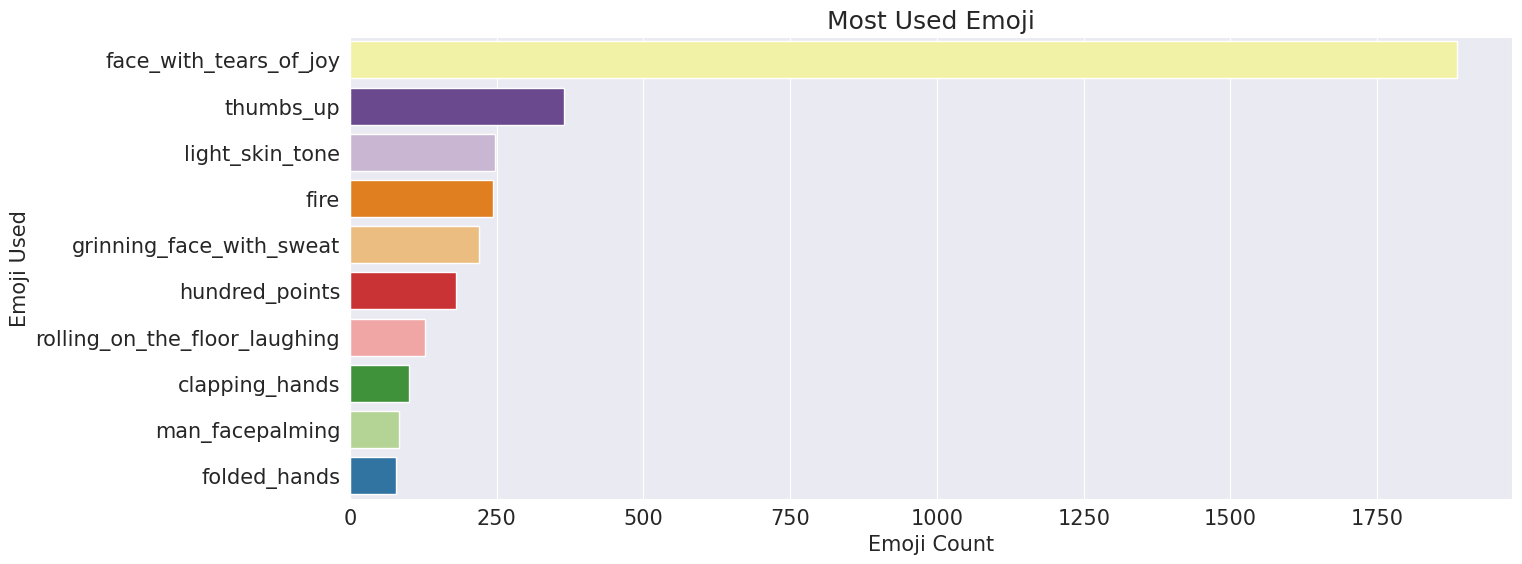

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readability
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting
sns.barplot(x='emoji_count', y='emoji_description', data=top10emojis, palette="Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used')

# Saving the plots
plt.savefig('top10emoji.svg', format='svg')

# Display the plot
plt.show()


#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [40]:
import pandas as pd

# Create a copy of the DataFrame
df3 = df.copy()

# Add a helper column to keep a count of messages
df3['message_count'] = 1

# Extract the hour from the 'date_time' column
df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

# Group by hour and count the number of messages in each hour
grouped_by_time = df3.groupby('hour')['message_count'].count().reset_index()

# Rename columns for better readability
grouped_by_time.columns = ['hour', 'message_count']

# Display the result
print(grouped_by_time)


    hour  message_count
0      0            490
1      1            235
2      2            219
3      3            125
4      4             36
5      5             21
6      6              3
7      7             32
8      8             86
9      9            215
10    10            445
11    11            594
12    12            959
13    13            904
14    14           1138
15    15            570
16    16            519
17    17           1109
18    18            727
19    19            764
20    20            849
21    21           1267
22    22           1194
23    23           1154


### Which hour of the day are most messages exchanged?

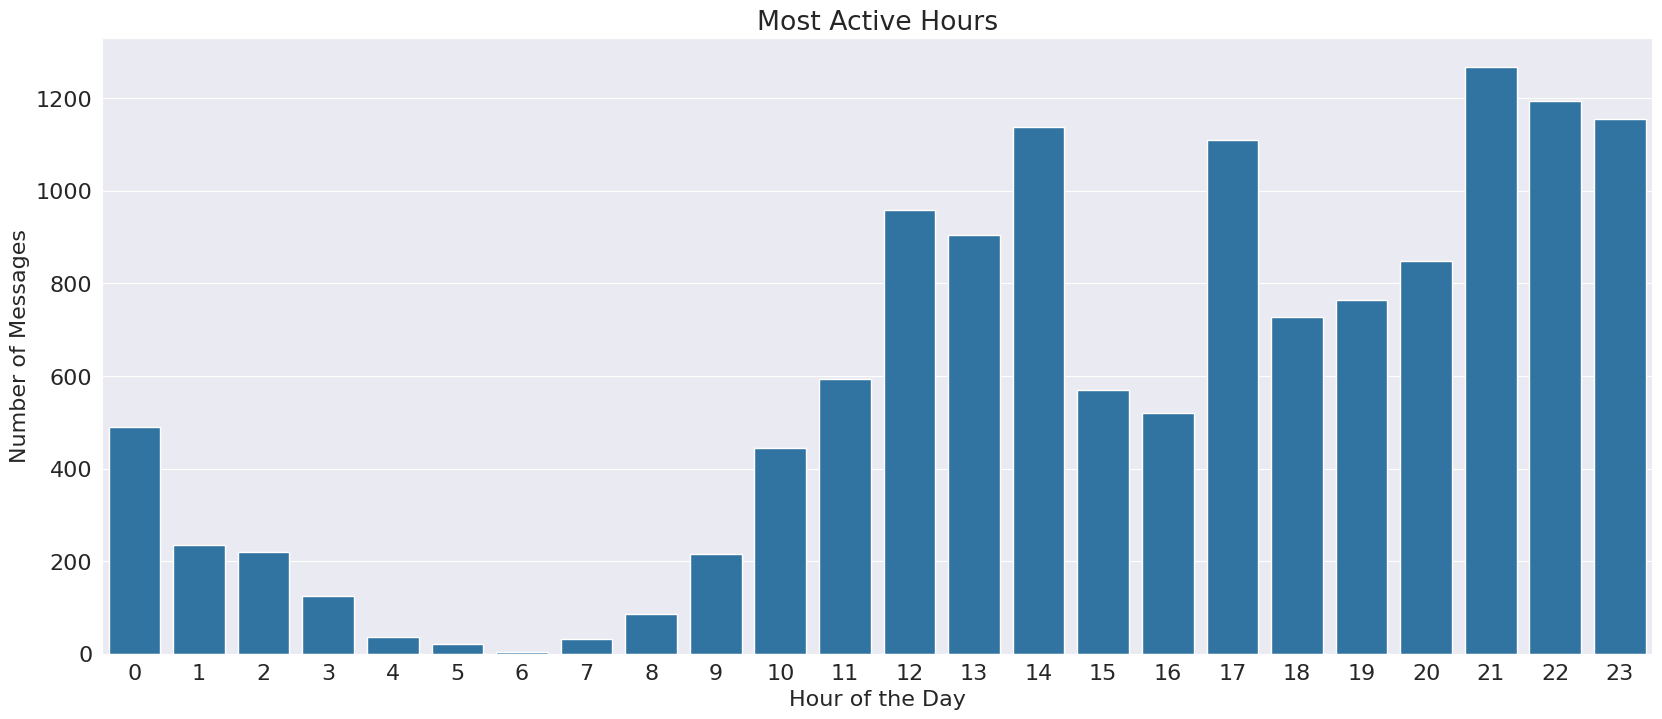

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x='hour', y='message_count', data=grouped_by_time)
plt.title('Most Active Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')

# Saving the plot
plt.savefig('most_active_hours.svg', format='svg')

# Show the plot
plt.show()


#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

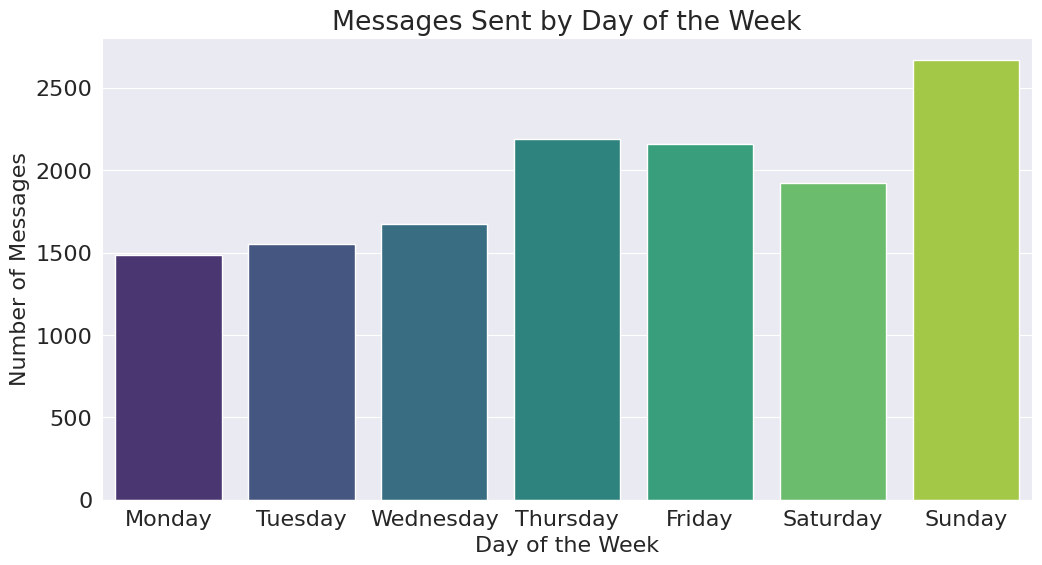

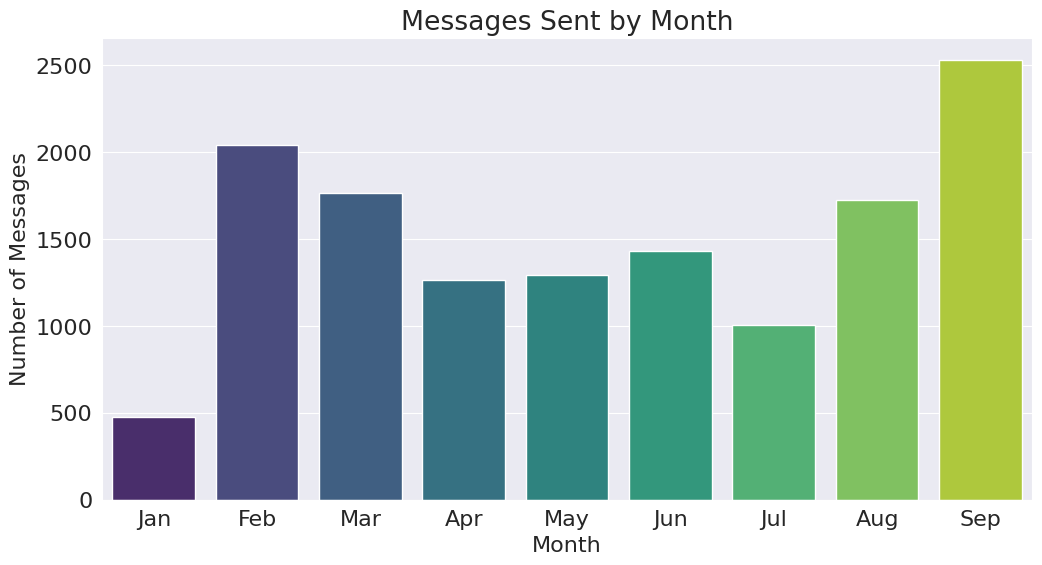

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper column to keep a count of messages
df3['message_count'] = 1

# Extracting the day name and month name from the date_time column
df3['day'] = df3['date_time'].dt.day_name()
df3['month'] = df3['date_time'].dt.strftime('%b')  # %b gives abbreviated month name

# specific `order` to be printed in
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till September

# Grouping by day
grouped_by_day = df3.groupby('day')['message_count'].count().reset_index()
grouped_by_day['day'] = pd.Categorical(grouped_by_day['day'], categories=days, ordered=True)
grouped_by_day = grouped_by_day.sort_values('day')

# Grouping by month
grouped_by_month = df3.groupby('month')['message_count'].count().reset_index()
grouped_by_month['month'] = pd.Categorical(grouped_by_month['month'], categories=months, ordered=True)
grouped_by_month = grouped_by_month.sort_values('month')

# Plotting grouped by day
plt.figure(figsize=(12, 6))
sns.barplot(x='day', y='message_count', data=grouped_by_day, palette='viridis')
plt.title('Messages Sent by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Messages')
plt.savefig('messages_by_day.svg', format='svg')
plt.show()

# Plotting grouped by month
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='message_count', data=grouped_by_month, palette='viridis')
plt.title('Messages Sent by Month')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.savefig('messages_by_month.svg', format='svg')
plt.show()


## *Visualization*
### Now, we will be plotting *grouped by day* and respective *group by month* simultaneously, to see some interesting results.
- Using `plt.subplots` to plot multiple charts in a grid.

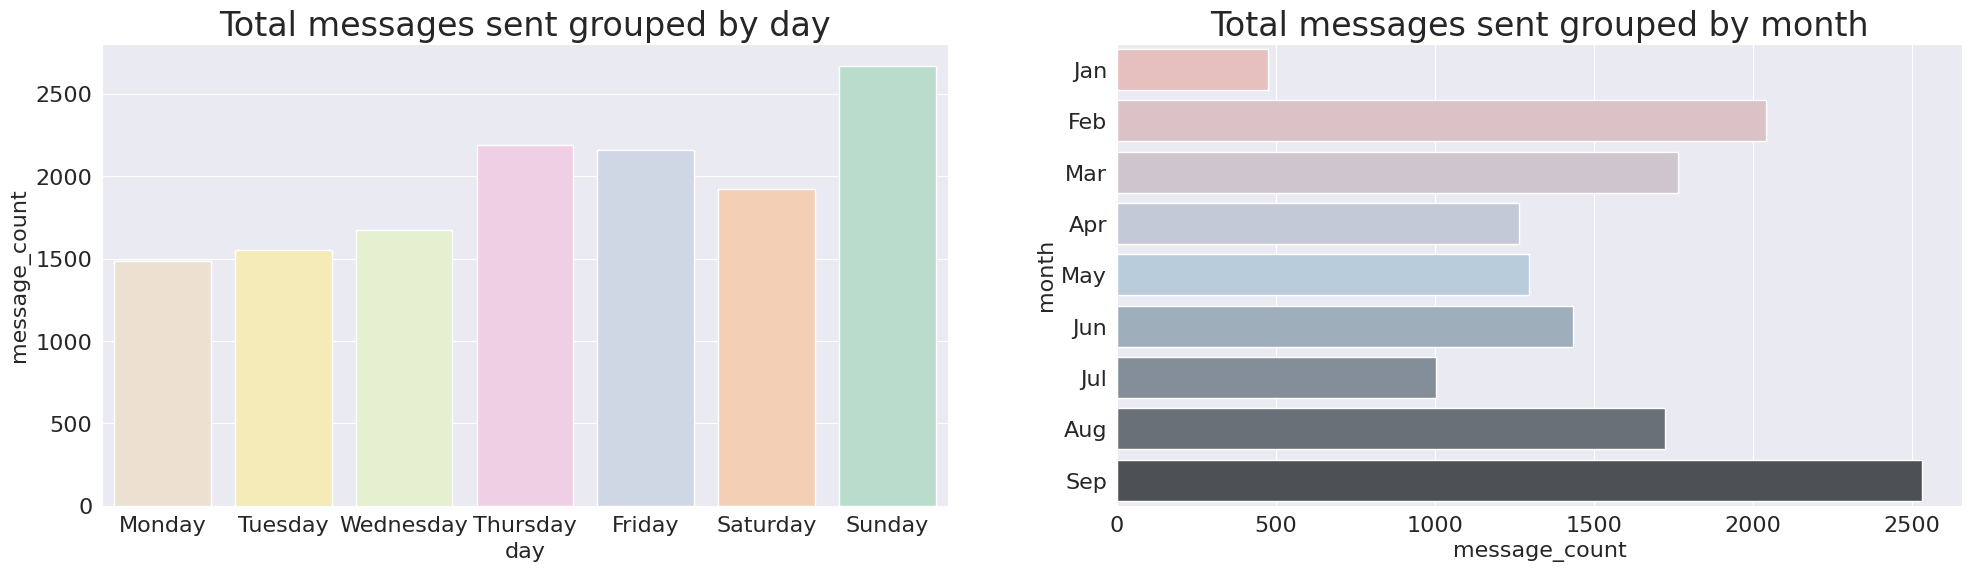

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Helper column to keep a count of messages
df3['message_count'] = 1

# Extracting the day name and month name from the date_time column
df3['day'] = df3['date_time'].dt.day_name()
df3['month'] = df3['date_time'].dt.strftime('%b')  # %b gives abbreviated month name

# specific `order` to be printed in
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till September

# Grouping by day
grouped_by_day = df3.groupby('day')['message_count'].count().reset_index()
grouped_by_day['day'] = pd.Categorical(grouped_by_day['day'], categories=days, ordered=True)
grouped_by_day = grouped_by_day.sort_values('day')

# Grouping by month
grouped_by_month = df3.groupby('month')['message_count'].count().reset_index()
grouped_by_month['month'] = pd.Categorical(grouped_by_month['month'], categories=months, ordered=True)
grouped_by_month = grouped_by_month.sort_values('month')

fig, axs = plt.subplots(1, 2, figsize=(24, 6))

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, ax=axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(x='message_count', y='month', data=grouped_by_month, ax=axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month')

# Saving the plots;
plt.savefig('days_and_month.svg', format='svg')
plt.show()


##### The group is most active on Sundays, and least active on Mondays (probably *Monday Blues*)
##### It has been recently very active, in September.

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding!

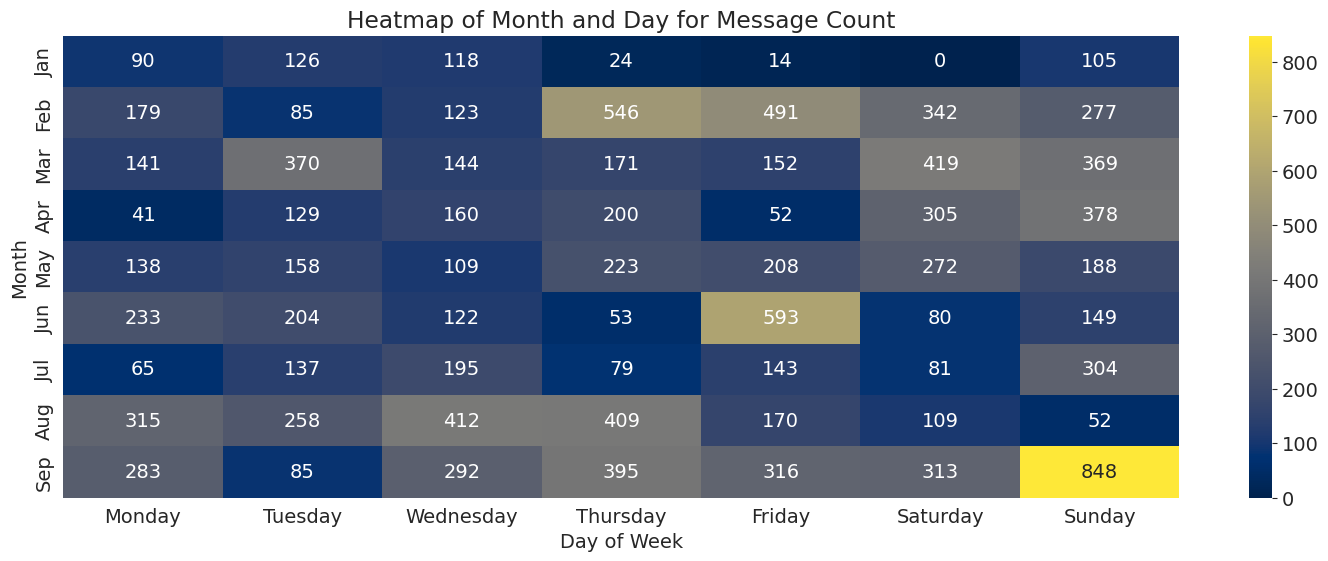

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Helper column to keep a count of messages
df3['message_count'] = 1

# Extracting the day name and month name from the date_time column
df3['day'] = df3['date_time'].dt.day_name()
df3['month'] = df3['date_time'].dt.strftime('%b')  # %b gives abbreviated month name

# specific `order` to be printed in
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till September

# Grouping by month and day
grouped_by_month_and_day = df3.groupby(['month', 'day']).count().reset_index()[['month', 'day', 'message_count']]

# Creating a pivot table and filling missing values with zeros
pt = grouped_by_month_and_day.pivot_table(index='month', columns='day', values='message_count', aggfunc='sum', fill_value=0).reindex(index=months, columns=days)

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: heatmap
sns.heatmap(pt, cmap='cividis', annot=True, fmt="d")
plt.title('Heatmap of Month and Day for Message Count')
plt.xlabel('Day of Week')
plt.ylabel('Month')

# Saving the plots
plt.savefig('month_day_heatmap.svg', format='svg')
plt.show()


# *Inferences*
- The group is more active on weekends, throughout the months.
- September has the most lighter blue shades and more yellow gradients.
- This gives a combined analysis, which is really helpful in real-time projects.

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [45]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:

    # typecaste each val to string.
    val = str(val)

    # split the value.
    tokens = val.split()

    # Converts each token into lowercase.
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for words in tokens:
        comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 8).generate(comment_words)

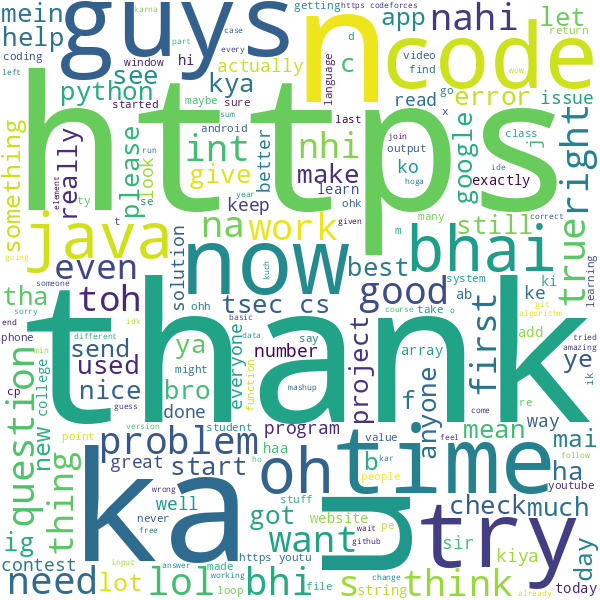

In [46]:
wordcloud.to_image()

In [48]:
!pip install stylecloud

from stylecloud import gen_stylecloud
from wordcloud import STOPWORDS

# Initialize an empty string to store all words
comment_words = ''

# Define stopwords to be avoided while forming the word cloud
stopwords = set(STOPWORDS)
stopwords.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])

# Iterate through the DataFrame to extract words from messages
for val in df3.message.values:
    # Typecast each message value to string
    val = str(val)
    # Split the value into tokens
    tokens = val.split()
    # Convert each token into lowercase and append to the comment_words string
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens) + " "

# Generate the word cloud using stylecloud
gen_stylecloud(text=comment_words,
               icon_name='fas fa-comment',  # Choose an icon for the word cloud
               palette='colorbrewer.qualitative.Set2_8',  # Choose a color palette
               background_color='white',  # Set background color
               gradient='horizontal',  # Set gradient direction
               output_name='styled_wordcloud.png'  # Set output file name
               )


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259494 sha256=c615becaf55986b2e99ca6331eed5c68c6bf45ceb0b0fe0b10bcbf25e2251597
  Stored in directory: /root/.cache/pip/wheels/aa/c8/27/9374f4fc7133015d902b5e2c75ad951edd57eb1ae948495915
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=d32d32025809014aa50568205fccd91610fb642edba499a258970cbcb3bd53af
  Stored in directory: /root/.cache/pip/wheels/d6/6d/

#Sentiment analysis
*Sentiment labels*
To perform sentiment analysis on the messages in the provided data, we can use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool, which is available in the NLTK (Natural Language Toolkit) library. Here's how you can do it:

In [49]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for each message
def get_sentiment_score(message):
    # Calculate the sentiment scores for the message
    scores = sid.polarity_scores(message)
    # Return the compound sentiment score
    return scores['compound']

# Apply the sentiment analysis function to each message in the DataFrame
df3['sentiment_score'] = df3['message'].apply(get_sentiment_score)

# Classify messages as positive, negative, or neutral based on the sentiment score
df3['sentiment'] = df3['sentiment_score'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))

# Display the DataFrame with sentiment scores and classifications
print(df3[['message', 'sentiment_score', 'sentiment']])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                                 message  sentiment_score  \
0      Messages and calls are end-to-end encrypted. N...          -0.2960   
1      Tanay Kamath (TSEC, CS) created group "CODERS👨...           0.2500   
2             You joined using this group's invite link            0.1531   
3      +91 99871 38558 joined using this group's invi...           0.1531   
4      +91 91680 38866 joined using this group's invi...           0.1531   
...                                                  ...              ...   
13650                                    MCQs mark kiya            0.0000   
13651                                    Sign-in kiya😂😅            0.0000   
13652                                  Incognito se na?            0.0000   
13653                                               Yup            0.0000   
13654  guys, please do me a favor and vote in this po...           0.8750   

      sentiment  
0      negative  
1      positive  
2      positive  
3  

Sentiment Distribution

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


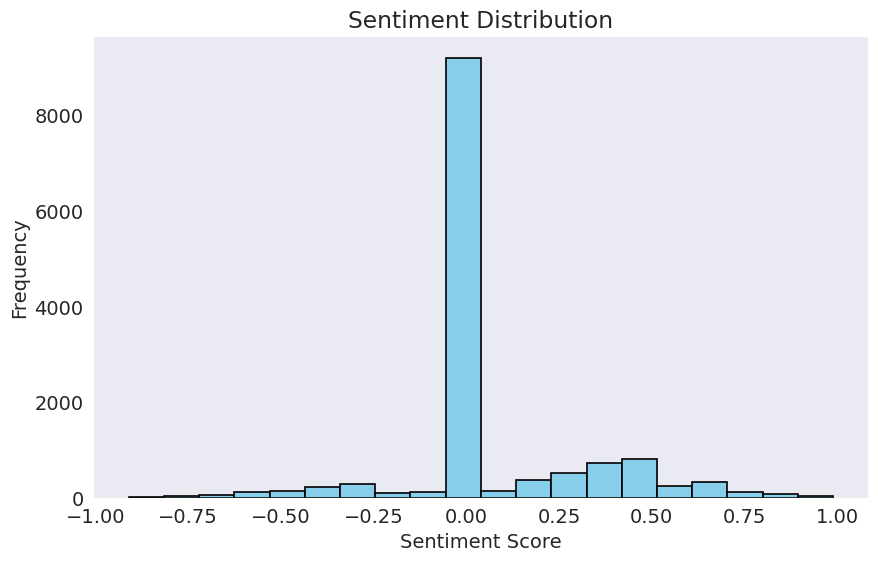

In [51]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Download necessary NLTK data (if not already downloaded)
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for each message
def get_sentiment_score(message):
    # Compute sentiment scores
    scores = sid.polarity_scores(message)
    # Return the compound score
    return scores['compound']

# Apply the function to compute sentiment scores for each message
df3['sentiment_score'] = df3['message'].apply(get_sentiment_score)

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
df3['sentiment_score'].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


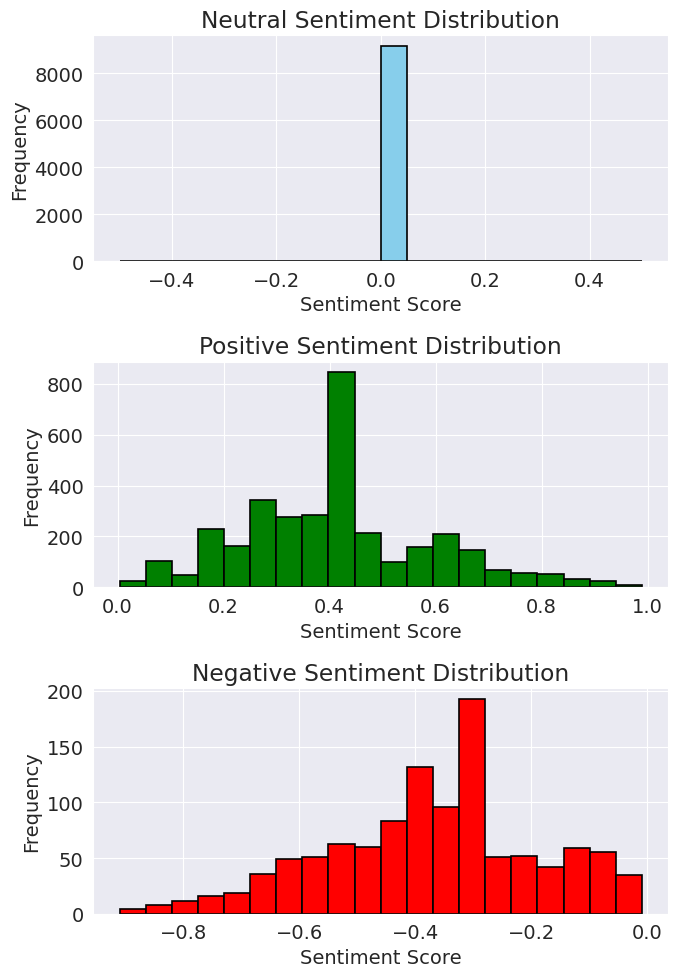

In [52]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(7, 10))

# Plot distribution of neutral scores
axs[0].hist(df3[df3['sentiment_score'] == 0]['sentiment_score'], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
axs[0].set_title('Neutral Sentiment Distribution')
axs[0].set_xlabel('Sentiment Score')
axs[0].set_ylabel('Frequency')

# Plot distribution of positive scores
axs[1].hist(df3[df3['sentiment_score'] > 0]['sentiment_score'], bins=20, color='green', edgecolor='black', linewidth=1.2)
axs[1].set_title('Positive Sentiment Distribution')
axs[1].set_xlabel('Sentiment Score')
axs[1].set_ylabel('Frequency')

# Plot distribution of negative scores
axs[2].hist(df3[df3['sentiment_score'] < 0]['sentiment_score'], bins=20, color='red', edgecolor='black', linewidth=1.2)
axs[2].set_title('Negative Sentiment Distribution')
axs[2].set_xlabel('Sentiment Score')
axs[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


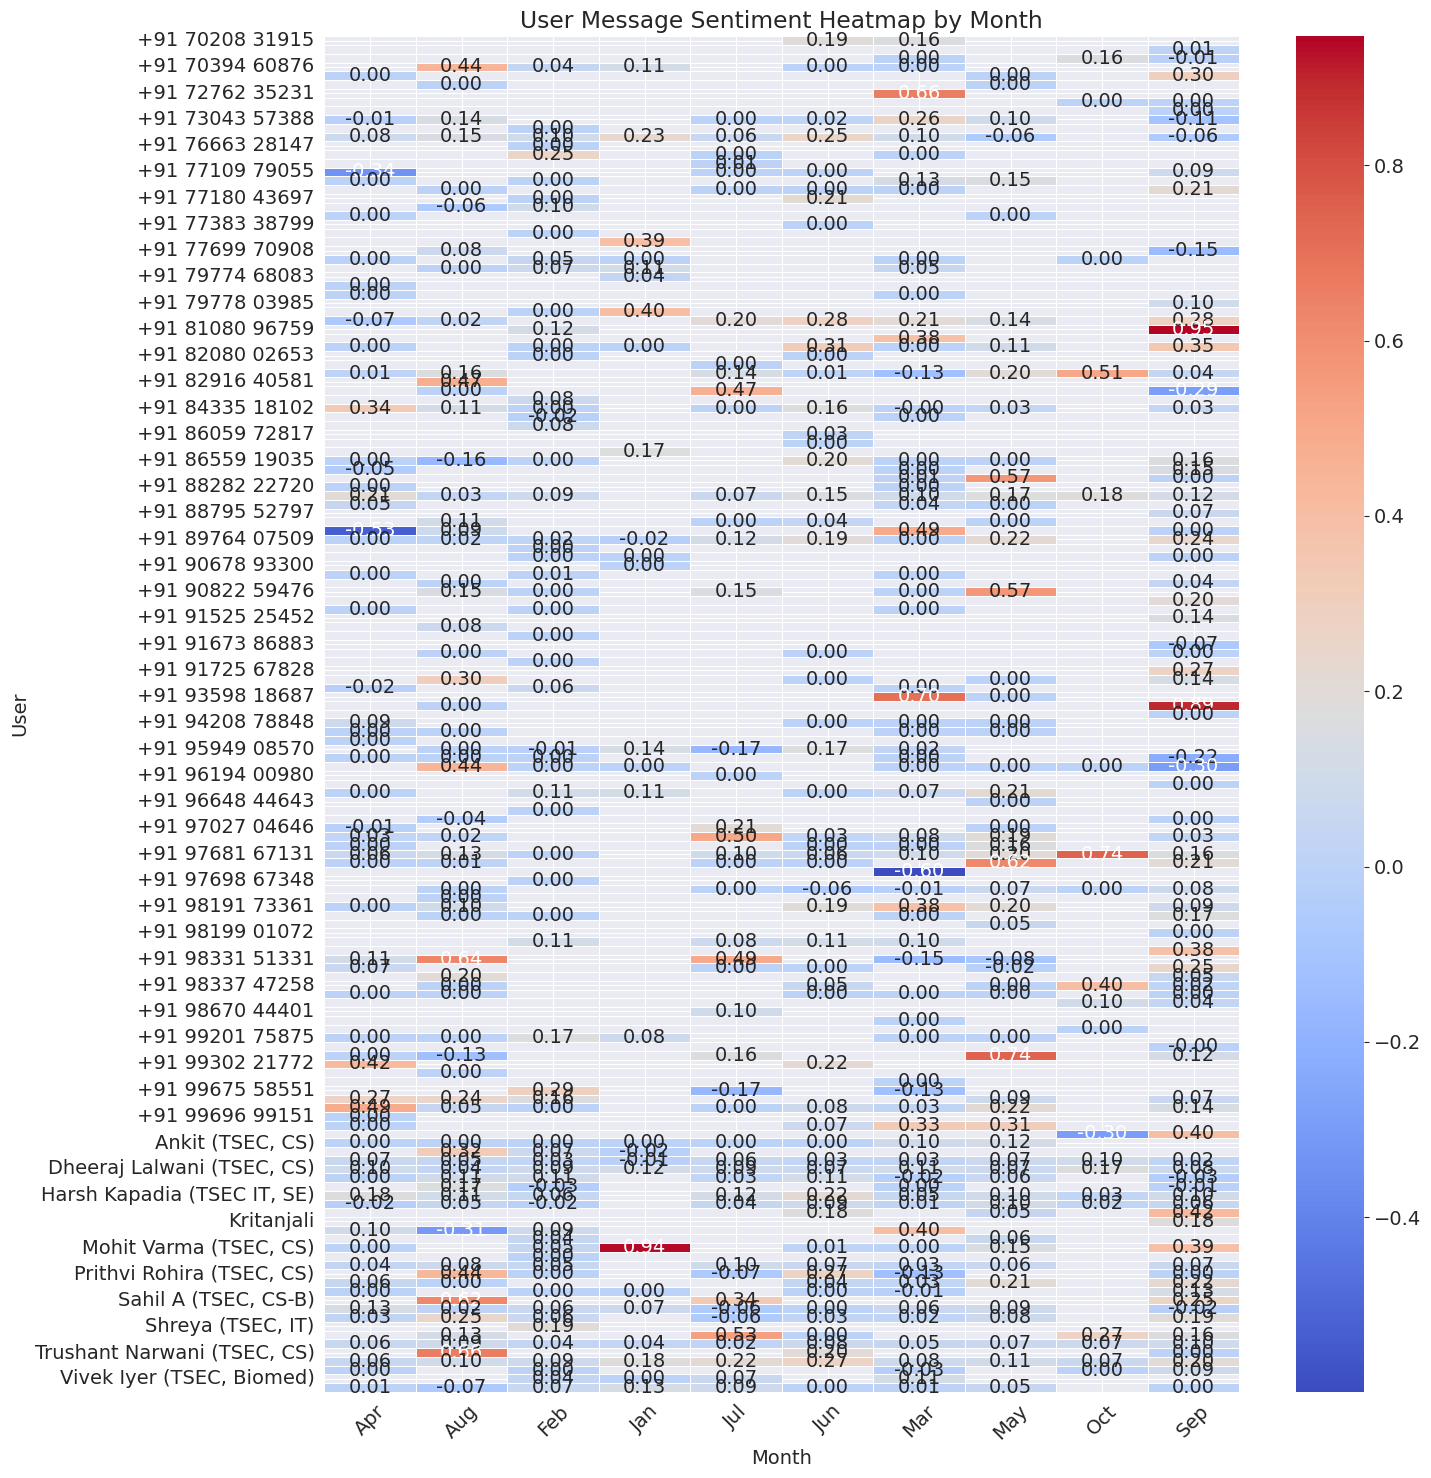

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table to get sentiment scores for each user and month
sentiment_pivot = df3.pivot_table(index='user', columns='month', values='sentiment_score', aggfunc='mean')

# Create heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(sentiment_pivot, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('User Message Sentiment Heatmap by Month')
plt.xlabel('Month')
plt.ylabel('User')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Ensure y-axis labels are horizontal
plt.tight_layout()
plt.show()


Topic Modelling

In [54]:
!pip install bertopic umap hdbscan

from bertopic import BERTopic
from umap import UMAP
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.5

In [55]:
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, _ = topic_model.fit_transform(df3['message'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [56]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3367,-1_it_to_the_and,"[it, to, the, and, is, of, in, for, not, but]","[In today's world, basic programming skills ar..."
1,0,1195,0_ikr_ohk_ik_ty,"[ikr, ohk, ik, ty, amazing, mastt, yess, wtf, ...","[Ohk👍 , Ikr😭 , Ikr😂 ]"
2,1,688,1_omitted_media_clips_audio,"[omitted, media, clips, audio, removing, mediu...","[<Media omitted> , <Media omitted> , <Media om..."
3,2,541,2_bennett_gold_sparsh_,"[bennett, gold, sparsh, , , , , , , ]","[Sparsh , Gold , Bennett* ]"
4,3,318,3_deleted_message_was_this,"[deleted, message, was, this, messages, delete...","[This message was deleted , This message was d..."
...,...,...,...,...,...
223,222,11,222_backend_front_end_frontend,"[backend, front, end, frontend, functionality,...","[Why front end? , That's just the backend budd..."
224,223,11,223_fe_fes_ant_cargo,"[fe, fes, ant, cargo, orange, impressed, fox, ...","[From fe , FE? , FE ]"
225,224,11,224_python_java_allows_affect,"[python, java, allows, affect, poorly, javapyt...",[Yes that’s toh obvious but I don’t know since...
226,225,11,225_yeahh_yeahhh_dudeeew_dammmm,"[yeahh, yeahhh, dudeeew, dammmm, yeahhhhh, dam...","[Yeahh , Yeahh , Yeahh ]"


Plot bar chart for the topics

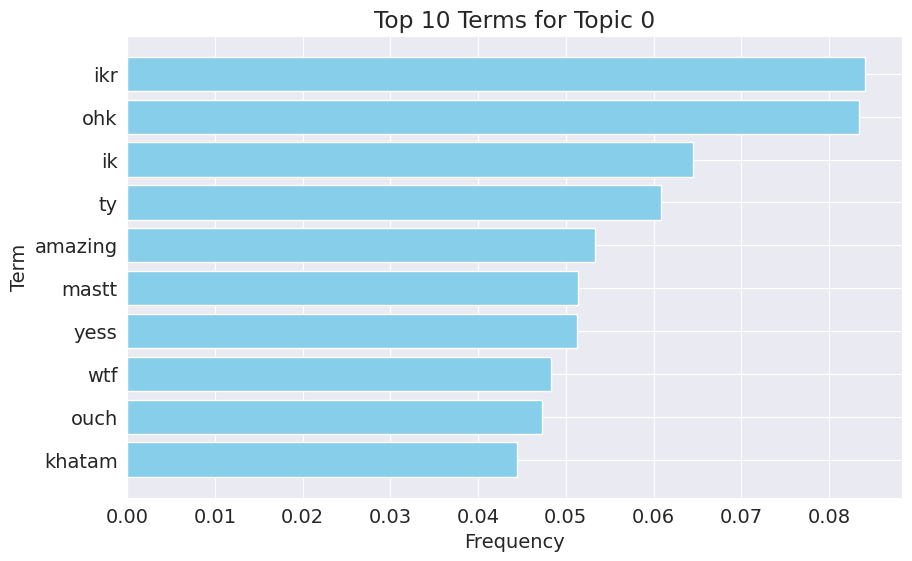

In [57]:
# Create bar chart
import matplotlib.pyplot as plt

# Extract topic terms and their frequencies
topic_terms = topic_model.get_topics()
selected_topic = 0  # Change this to the index of the topic you want to plot

# Check if the selected topic exists
if selected_topic in topic_terms:
    terms, frequencies = zip(*topic_terms[selected_topic])  # Unpack the tuples
    top_terms = terms[:10]  # Select top terms
    top_frequencies = frequencies[:10]  # Select corresponding frequencies

    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_terms, top_frequencies, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Term')
    plt.title('Top 10 Terms for Topic {}'.format(selected_topic))
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()
else:
    print("Selected topic does not exist.")


**Term score decline:**
To visualize the decline in term scores across topics, you can plot the scores of a particular term across different topics. Here's how you can do it:

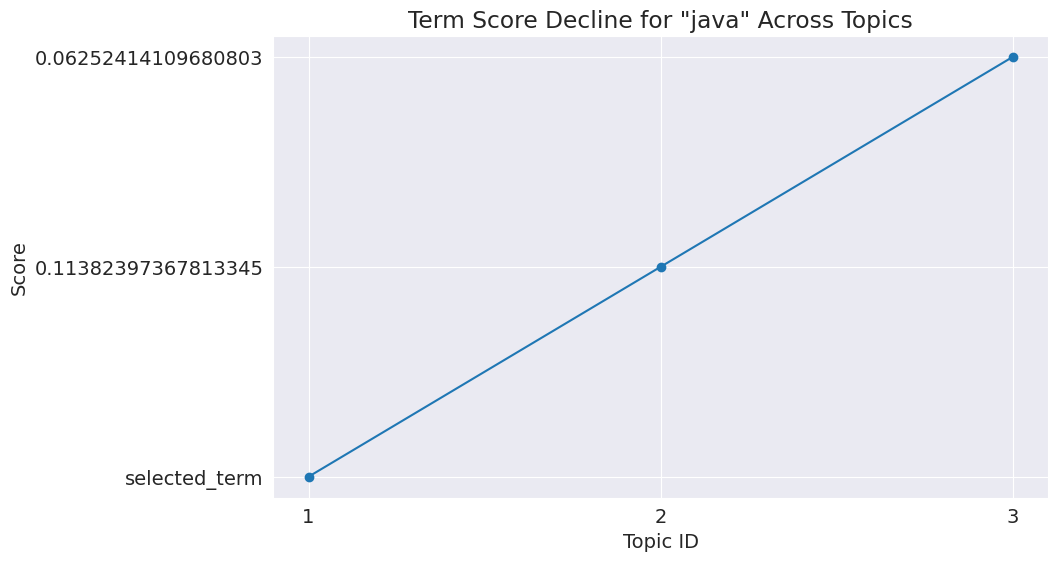

In [58]:
import matplotlib.pyplot as plt

# Specify the term for which you want to visualize the score decline
selected_term = "java"

# Get the scores of the selected term across all topics
term_scores = ['selected_term']

for topic_id, terms in topic_terms.items():
    for term, score in terms:
        if term == selected_term:
            term_scores.append(score)

# Plot the decline in scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(term_scores) + 1), term_scores, marker='o', linestyle='-')
plt.xlabel('Topic ID')
plt.ylabel('Score')
plt.title('Term Score Decline for "{}" Across Topics'.format(selected_term))
plt.xticks(range(1, len(term_scores) + 1))
plt.grid(True)
plt.show()


In [59]:
import pandas as pd

# Example DataFrame structure as a dictionary
data = {
    'time_interval': ['Jan-2024', 'Jan-2024', 'Feb-2024', 'Feb-2024'],
    'topic': [0, 1, 0, 1],
    'message_count': [10, 20, 15, 25]
}

# Create DataFrame
topic_time_df = pd.DataFrame(data)

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = topic_time_df.pivot(index="topic", columns="time_interval", values="message_count")

# Display the DataFrame
print(heatmap_data)


time_interval  Feb-2024  Jan-2024
topic                            
0                    15        10
1                    25        20


Topic similarity
1. Intertopic distance map

In [60]:
import pandas as pd
from bertopic import BERTopic

# Assuming you have a DataFrame named 'df' containing your text data
# Preprocess the text data
def preprocess_text(text):
    # Implement your text preprocessing steps here
    # For example, convert text to lowercase, remove punctuation, etc.
    return text

df['clean_msg'] = df['message'].apply(preprocess_text)

# Create the corpus
corpus = df['clean_msg'].tolist()

# Initialize and fit the BERTopic model
model = BERTopic()
topics, _ = topic_model.fit_transform(corpus)

# Now 'topics' contains the topic assignments for each document in your corpus
# You can explore the topics further using methods provided by the BERTopic library



In [61]:
# Visualize topics with a custom number of topics
fig = topic_model.visualize_barchart()
fig


In [62]:
topic_model.visualize_topics()

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize and fit the BERTopic model
model = BERTopic()
topics, _ = model.fit_transform(corpus)

# Get topic embeddings
topic_embeddings = model.transform(corpus)

# Calculate cosine similarity between topic embeddings
similarity_matrix = cosine_similarity(topic_embeddings)

# Display the similarity matrix
print(similarity_matrix)




[[1.         0.64984594]
 [0.64984594 1.        ]]


In [64]:
# Visualize the topic hierarchy
topic_model.visualize_hierarchy()


In [65]:
# Choose a random message from your data
random_message = "My soln in Python"

# Transform the random message into its topic probability distribution
topic_probabilities =topic_model.transform([random_message])

# Print the topic probability distribution
print(topic_probabilities)


([-1], array([[1.56512806e-21, 1.57282343e-21, 1.67369523e-21, 1.70389789e-21,
        3.13907102e-04, 1.28100006e-20, 4.84822409e-04, 3.33725348e-04,
        2.23620313e-21, 3.69764351e-21, 4.05528757e-04, 6.13231892e-04,
        4.81265946e-04, 4.36832516e-04, 1.44707841e-20, 8.30249957e-04,
        4.19993145e-04, 5.07088513e-21, 5.44700189e-04, 6.80980856e-04,
        4.23808584e-04, 2.33153144e-21, 6.00941387e-04, 2.84484497e-21,
        5.86429179e-04, 1.13531492e-20, 3.41830473e-04, 4.25160996e-18,
        5.64707069e-21, 5.19863327e-04, 4.54683087e-04, 5.29160011e-04,
        2.01940445e-21, 3.05080981e-21, 4.98185701e-04, 6.20616084e-21,
        3.35295399e-04, 5.98426061e-04, 4.99305262e-04, 1.08190803e-20,
        4.27371974e-04, 6.01318179e-04, 7.13918626e-04, 2.90402597e-04,
        4.41225163e-21, 3.15361882e-21, 6.14097679e-04, 5.22493634e-04,
        4.72096804e-04, 2.31970102e-21, 4.26317198e-04, 4.63350988e-04,
        7.30534646e-04, 2.44560213e-21, 4.71313451e-04, 3

# *Conclusion*

- The insights were really interesting to look at!

- We first loaded the data as a .txt file coverted it using `RawtoDF` function.
- Then  we added helper columns, manipulated datetime entries.
- Then, we started analysing our whatsapp data!

Here is what we looked at!

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist - Most active user had the least average message length ).**
- Ghosts present in the group. (shocking results - 80+ participants who haven't even sent a single message!)

**4. Top 10 users most sent media.**
- *TK* beats everyone by a mile!

**5. Top 10 most used emojis.**
- using the `emoji` module!

**6. Most active hours and weekdays.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

### That's it from my end! I hope you *learnt and enjoyed* a lot!

# *Where to go from here?*

- Extending this **Whatsapp Analysis Project**!
  - Adding a **Sentiment Analyser to the texts** - Swear Words & Sentiments!
  - Libraries called `profanity_check`, `TextBlob`
  - VADER (Valence Aware Dictionary and Sentiment Reasoner) from NTLK and TextBlob.
- Instagram Data Analysis
- Play Store Data Analysis
- Exploring more datasets! It is *never-ending*, as there can be ***Infinite Stories with Data***!
- Once, done with enough Data Analysis, try making Datasets, scraping Data from websites and creating Interesting Datasets!

In [66]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Ensure required NLTK data packages are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [67]:
!pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.7 MB/s eta 0:00:00


In [68]:
import pandas as pd
import re
from datetime import datetime

# Function to parse a single line of the chat
def parse_line(line):
    # WhatsApp chat format: [date], [time] - [sender]: [message]
    pattern = r'^(\d{1,2}/\d{1,2}/\d{2,4}),\s(\d{1,2}:\d{2})\s-\s(.+?):\s(.+)$'
    match = re.match(pattern, line)
    if match:
        date, time, sender, message = match.groups()
        datetime_str = f'{date} {time}'

        # Try different date formats to see which one works
        try:
            datetime_obj = datetime.strptime(datetime_str, '%d/%m/%y %H:%M')
        except ValueError:
            try:
                datetime_obj = datetime.strptime(datetime_str, '%m/%d/%y %H:%M')
            except ValueError:
                try:
                    datetime_obj = datetime.strptime(datetime_str, '%d/%m/%Y %H:%M')
                except ValueError:
                    datetime_obj = datetime.strptime(datetime_str, '%m/%d/%Y %H:%M')

        return datetime_obj, sender, message
    return None, None, None

# Read the chat file
file_path = 'whatsapp-chat-data.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Parse the chat lines
# Print the first few lines to understand the format
print("First few lines of the chat file:")
for i in range(5):
    print(lines[i].strip())
# Parse the chat lines
data = []
for line in lines:
    datetime_obj, sender, message = parse_line(line)
    if datetime_obj and sender and message:
        data.append([datetime_obj, sender, message])
    else:
        print(f"Line skipped: {line.strip()}")

# Create DataFrame
df = pd.DataFrame(data, columns=['datetime', 'sender', 'message'])

# Display the DataFrame
print(df.head())


Streaming output truncated to the last 5000 lines.
Line skipped: 24/08/2020, 11:46 am - Kartik Soneji (TSEC, CS): 😂
Line skipped: 24/08/2020, 11:46 am - +91 99204 26955: Nothing will happen
Line skipped: Don’t sit for any lectures
Line skipped: 24/08/2020, 11:47 am - +91 80979 84068: Pro tip
Line skipped: 24/08/2020, 11:47 am - Dheeraj Lalwani (TSEC, CS): No consequences?
Line skipped: Attendance locha vagere?
Line skipped: 24/08/2020, 11:47 am - +91 99204 26955: No no
Line skipped: 24/08/2020, 11:47 am - Dheeraj Lalwani (TSEC, CS): Great then
Line skipped: 24/08/2020, 11:47 am - +91 99204 26955: Which subjects do you have?
Line skipped: 24/08/2020, 11:47 am - Kartik Soneji (TSEC, CS): Meeting join toh kar.
Line skipped: 24/08/2020, 11:47 am - Kartik Soneji (TSEC, CS): Usme kya jata hai.
Line skipped: 24/08/2020, 11:47 am - +91 99204 26955: And just mute them
Line skipped: 24/08/2020, 11:48 am - Dheeraj Lalwani (TSEC, CS): M3
Line skipped: DLCOA
Line skipped: CG
Line skipped: DS
Line s

In [69]:
# Create DataFrame
df = pd.DataFrame(data, columns=['datetime', 'sender', 'message'])

# Display the DataFrame
print(df.head())

Empty DataFrame
Columns: [datetime, sender, message]
Index: []


#Modelling of:                        
Sentiment Analysis of the group chat

What is Sentiment Analysis?
Sentiment analysis is a natural language processing technique used to determine whether data is positive, negative or neutral. Sentiment analysis is often performed on textual data to help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.\

#Step 1: Data Preprocessing
Load and inspect the data:
Ensure the data is loaded correctly and inspect the first few rows.

In [70]:
df3.head(10)

,date_time,user,message,day,month,year,date,message_length,message_count,hour,sentiment_score,sentiment
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sunday,Jan,2020,2020-01-26,140,1,16,-0.2960,negative
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Friday,Jan,2020,2020-01-24,55,1,20,0.2500,positive
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sunday,Jan,2020,2020-01-26,42,1,16,0.1531,positive
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive
5,2020-01-26 16:22:00,group_notification,+91 72762 35231 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive
6,2020-01-26 16:22:00,group_notification,+91 88392 06534 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive
7,2020-01-26 16:23:00,group_notification,+91 98709 38217 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive
8,2020-01-26 16:23:00,group_notification,+91 98702 02065 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive
9,2020-01-26 16:23:00,group_notification,+91 91370 44426 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,positive


In [71]:
df3[['message', 'sentiment']]
df3.headdf3 = ()

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_time        13655 non-null  datetime64[ns]
 1   user             13655 non-null  object        
 2   message          13655 non-null  object        
 3   day              13655 non-null  object        
 4   month            13655 non-null  object        
 5   year             13655 non-null  int32         
 6   date             13655 non-null  object        
 7   message_length   13655 non-null  int64         
 8   message_count    13655 non-null  int64         
 9   hour             13655 non-null  int64         
 10  sentiment_score  13655 non-null  float64       
 11  sentiment        13655 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(6)
memory usage: 1.2+ MB


In [74]:
df3.isnull().sum()

date_time          0
user               0
message            0
day                0
month              0
year               0
date               0
message_length     0
message_count      0
hour               0
sentiment_score    0
sentiment          0
dtype: int64

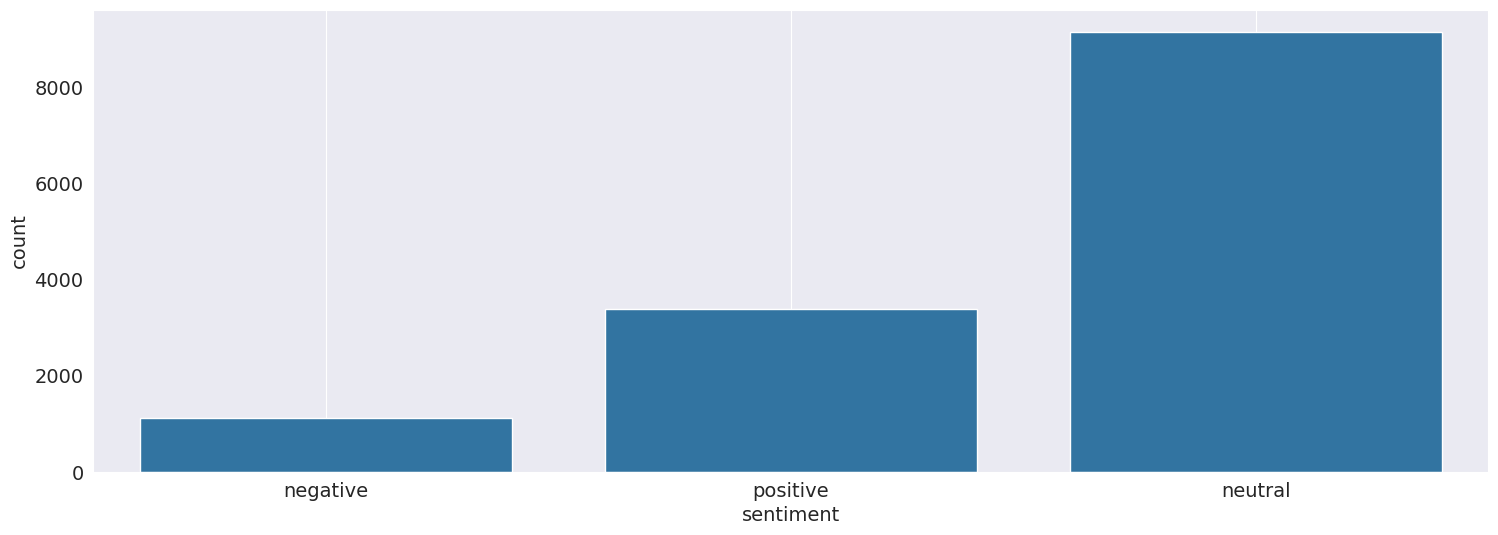

In [75]:
sns.countplot(x=df3['sentiment'])
plt.grid()

In [76]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df3['sentiment'] = label_encoder.fit_transform(df3['sentiment'])


In [77]:
# Check the unique values in the sentiment column
unique_sentiments = df3['sentiment'].unique()
print(f"Unique sentiment values: {unique_sentiments}")


Unique sentiment values: [0 2 1]


In [78]:
#Creating a new column 'length' that will contain the length of the string in 'message' column

df3['length'] = df3['message'].apply(len)
df3.head()

,date_time,user,message,day,month,year,date,message_length,message_count,hour,sentiment_score,sentiment,length
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sunday,Jan,2020,2020-01-26,140,1,16,-0.2960,0,140
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Friday,Jan,2020,2020-01-24,55,1,20,0.2500,2,55
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sunday,Jan,2020,2020-01-26,42,1,16,0.1531,2,42
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,2,54
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sunday,Jan,2020,2020-01-26,54,1,16,0.1531,2,54


In [79]:
df3 = df3[['message', 'sentiment']]

In [80]:
#Randomly checking for 10th record

print(f"'message' column value: {df3.iloc[10]['message']}") #Original value
print(f"Length of message : {len(df3.iloc[10]['message'])}") #Length of message using len()
#print(f"'length' column value : {df3.iloc[10]['length']}") #Value of the column 'length'

'message' column value: +91 86559 19035 joined using this group's invite link 
Length of message : 54


In [81]:
#Distinct values of 'sentiment' and its count

print(f"Sentiment value count: \n{df3['sentiment'].value_counts()}")

Sentiment value count: 
sentiment
1    9150
2    3390
0    1115
Name: count, dtype: int64


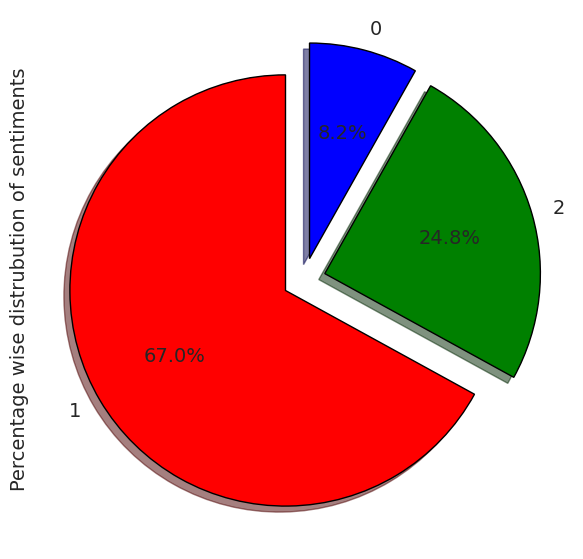

In [82]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df3['sentiment'].value_counts()/df3.shape[0]

explode=(0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of sentiments')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

#Preprocessing of df3

In [83]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df3.shape[0]):
  message = re.sub('[^a-zA-Z]', ' ', df3.iloc[i]['message'])
  message = message.lower().split()
  message = [stemmer.stem(word) for word in message if not word in STOPWORDS]
  message = ' '.join(message)
  corpus.append(message)

In [84]:
cv = CountVectorizer(max_features = 5000)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df3['sentiment'].values

In [85]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (13655, 5000)
y shape: (13655,)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (9558, 5000)
y train: (9558,)
X test: (4097, 5000)
y test: (4097,)


In [87]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 129
X test max value: 12


In [88]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [89]:
#Saving the scaler model
pickle.dump(scaler, open('./scaler.pkl', 'wb'))

In [90]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [91]:
# Print the accuracies formatted to 4 decimal places
training_accuracy = model_rf.score(X_train_scl, y_train)
testing_accuracy = model_rf.score(X_test_scl, y_test)

In [92]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))
# Print the accuracies formatted to 4 decimal places
print(f"Training Accuracy : {training_accuracy:.4f}")
print(f"Testing Accuracy : {testing_accuracy:.4f}")

Training Accuracy : 0.9875496965892446
Testing Accuracy : 0.8974859653404931
Training Accuracy : 0.9875
Testing Accuracy : 0.8975


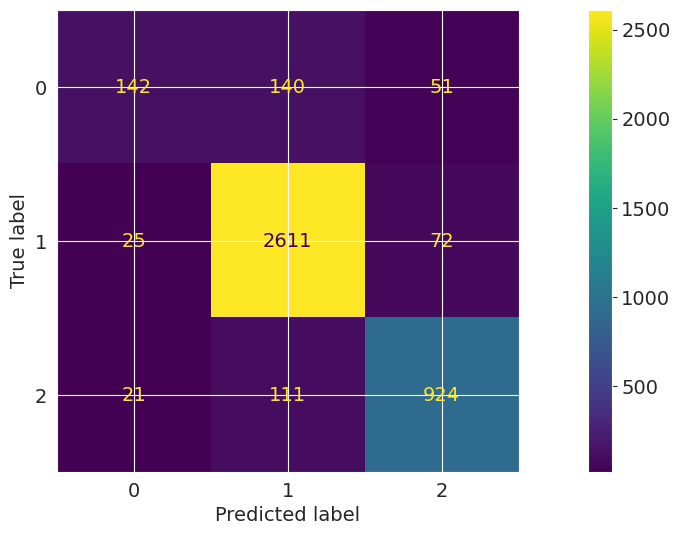

In [93]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()


In [94]:
#Saving the XGBoost classifier
pickle.dump(model_rf, open('./model_rf.pkl', 'wb'))

#K fold cross-validation

In [95]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9025952375736598
Standard Variance : 0.00597454886385539


In [96]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [97]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [98]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [99]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 91.05199832600962
Cross validation mean accuracy on test set : 87.14296924042686
Accuracy score for test set : 0.8974859653404931


In [100]:
#Model 2

In [101]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [102]:
#Accuracy of the model on training and testing data
# Print the accuracies formatted to 4 decimal places
training_accuracy = model_xgb.score(X_train_scl, y_train)
testing_accuracy = model_xgb.score(X_test_scl, y_test)

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

# Print the accuracies formatted to 4 decimal places
print(f"Training Accuracy : {training_accuracy:.4f}")
print(f"Testing Accuracy : {testing_accuracy:.4f}")

Training Accuracy : 0.9184975936388365
Testing Accuracy : 0.89455699292165
Training Accuracy : 0.9185
Testing Accuracy : 0.8946


In [103]:
y_preds_2 = model_xgb.predict(X_test)

In [104]:
cm_2 = confusion_matrix(y_test, y_preds_2)

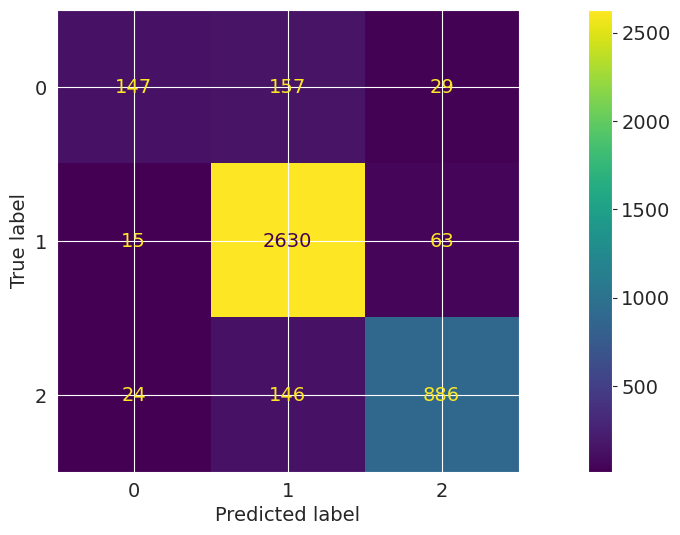

In [105]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_2,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [106]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('./model_xgb.pkl', 'wb'))

In [107]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc


# Precision
print()
print('Model Evaluation of RandomForestClassifier')
precision = precision_score(y_test, y_preds, average='weighted', zero_division=0)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_preds, average='weighted', zero_division=0)
print("Recall:", recall)




Model Evaluation of RandomForestClassifier
Precision: 0.8918647571168302
Recall: 0.8974859653404931


In [108]:
# AUC
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test set
y_prob = model_rf.predict_proba(X_test)

# Binarize the output labels for one-vs-rest (OvR) computation
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
# Compute AUC for each class
n_classes = y_test_bin.shape[1]
auc_scores = []

for i in range(n_classes):
    auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    auc_scores.append(auc)

# Average AUC scores (macro-averaging)
average_auc = np.mean(auc_scores)

print(f"Average AUC (macro) for RandomForestClassifier: {average_auc}")





Average AUC (macro) for RandomForestClassifier: 0.9336956001966291


In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc


# Precision
print()
print('Model Evaluation of Extreme Gradient Tree Classifier (xgboost classifier)')
precision = precision_score(y_test, y_preds_2, average='weighted', zero_division=0)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_preds_2, average='weighted', zero_division=0)
print("Recall:", recall)




Model Evaluation of Extreme Gradient Tree Classifier (xgboost classifier)
Precision: 0.8904281461293146
Recall: 0.8940688308518429


In [110]:
# AUC
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test set
y_prob = model_xgb.predict_proba(X_test)

# Binarize the output labels for one-vs-rest (OvR) computation
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
# Compute AUC for each class
n_classes = y_test_bin.shape[1]
auc_scores = []

for i in range(n_classes):
    auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    auc_scores.append(auc)

# Average AUC scores (macro-averaging)
average_auc = np.mean(auc_scores)

print(f"Average AUC (macro) for XGBoost: {average_auc}")





Average AUC (macro) for XGBoost: 0.9096429743102049
